In [50]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import files


In [51]:
latent_dims = 20
num_epochs = 30
batch_size = 256
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

In [52]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [53]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae_init = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae_init = vae_init.to(device)

num_params = sum(p.numel() for p in vae_init.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 647081


In [54]:
def train_vae_gen(vae, sample_vae=False, sample_from=None):

  device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
  vae = vae.to(device)

  num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
  print('Number of parameters: %d' % num_params)

  optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

  vae.train()

  train_loss_avg = []

  print('Training ...')
  for epoch in range(num_epochs):
      train_loss_avg.append(0)
      num_batches = 0

      for image_batch, _ in train_dataloader:

          image_batch = image_batch.to(device)

          if sample_vae:
            with torch.no_grad():
              # image_batch = image_batch.to(device)
              latent = torch.randn(image_batch.shape[0], latent_dims, device=device)
              image_batch = sample_from.decoder(latent)

          # vae reconstruction
          image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

          # reconstruction error
          loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

          # backpropagation
          optimizer.zero_grad()
          loss.backward()

          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()

          train_loss_avg[-1] += loss.item()
          num_batches += 1

      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [55]:
train_vae_gen(vae_init, False, None)

Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 42213.647515
Epoch [2 / 30] average reconstruction error: 29307.114046
Epoch [3 / 30] average reconstruction error: 27963.152468
Epoch [4 / 30] average reconstruction error: 27344.873629
Epoch [5 / 30] average reconstruction error: 26970.266967
Epoch [6 / 30] average reconstruction error: 26720.626853
Epoch [7 / 30] average reconstruction error: 26541.046576
Epoch [8 / 30] average reconstruction error: 26400.220529
Epoch [9 / 30] average reconstruction error: 26274.706005
Epoch [10 / 30] average reconstruction error: 26189.974904
Epoch [11 / 30] average reconstruction error: 26093.262192
Epoch [12 / 30] average reconstruction error: 26018.210131
Epoch [13 / 30] average reconstruction error: 25943.688614
Epoch [14 / 30] average reconstruction error: 25876.681774
Epoch [15 / 30] average reconstruction error: 25804.199676
Epoch [16 / 30] average reconstruction error: 25749.952872
Epoch [17 / 30] average

Original images


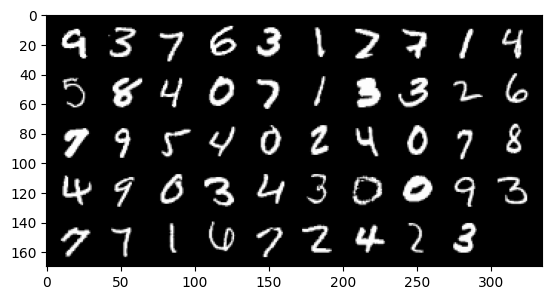

VAE reconstruction:


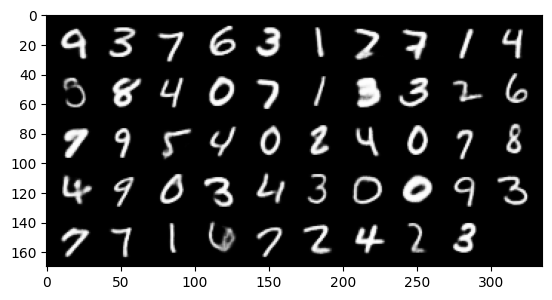

In [56]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae_init.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

for images, labels in test_dataloader:
  break

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae_init)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

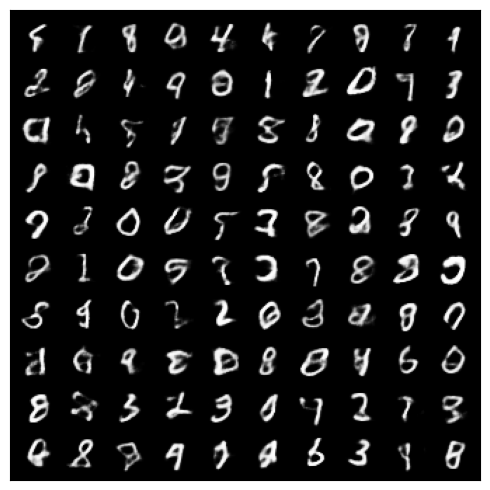

In [57]:
latent = torch.randn(128, latent_dims, device=device)

# reconstruct images from the latent vectors
img_recon = vae_init.decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

plt.savefig("vae_orig.pdf")
files.download("vae_orig.pdf")

0
Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 44539.862849
Epoch [2 / 30] average reconstruction error: 34492.264968
Epoch [3 / 30] average reconstruction error: 33372.997228
Epoch [4 / 30] average reconstruction error: 32959.302709
Epoch [5 / 30] average reconstruction error: 32635.651147
Epoch [6 / 30] average reconstruction error: 32416.611856
Epoch [7 / 30] average reconstruction error: 32210.921771
Epoch [8 / 30] average reconstruction error: 32124.267071
Epoch [9 / 30] average reconstruction error: 31996.979837
Epoch [10 / 30] average reconstruction error: 31960.523138
Epoch [11 / 30] average reconstruction error: 31900.338863
Epoch [12 / 30] average reconstruction error: 31879.206732
Epoch [13 / 30] average reconstruction error: 31845.857954
Epoch [14 / 30] average reconstruction error: 31799.885181
Epoch [15 / 30] average reconstruction error: 31729.728204
Epoch [16 / 30] average reconstruction error: 31733.766032
Epoch [17 / 30] avera

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1
Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 44562.223005
Epoch [2 / 30] average reconstruction error: 36464.327614
Epoch [3 / 30] average reconstruction error: 35627.400474
Epoch [4 / 30] average reconstruction error: 35269.426471
Epoch [5 / 30] average reconstruction error: 35130.585896
Epoch [6 / 30] average reconstruction error: 34970.780390
Epoch [7 / 30] average reconstruction error: 34937.594456
Epoch [8 / 30] average reconstruction error: 34846.376209
Epoch [9 / 30] average reconstruction error: 34740.596235
Epoch [10 / 30] average reconstruction error: 34731.636536
Epoch [11 / 30] average reconstruction error: 34702.984421
Epoch [12 / 30] average reconstruction error: 34679.319564
Epoch [13 / 30] average reconstruction error: 34647.451226
Epoch [14 / 30] average reconstruction error: 34669.912874
Epoch [15 / 30] average reconstruction error: 34621.656528
Epoch [16 / 30] average reconstruction error: 34624.807713
Epoch [17 / 30] avera

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2
Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 46321.565089
Epoch [2 / 30] average reconstruction error: 38414.407089
Epoch [3 / 30] average reconstruction error: 37712.352950
Epoch [4 / 30] average reconstruction error: 37394.913260
Epoch [5 / 30] average reconstruction error: 37172.599817
Epoch [6 / 30] average reconstruction error: 37081.902128
Epoch [7 / 30] average reconstruction error: 36995.989133
Epoch [8 / 30] average reconstruction error: 36930.743068
Epoch [9 / 30] average reconstruction error: 36957.744440
Epoch [10 / 30] average reconstruction error: 36841.876882
Epoch [11 / 30] average reconstruction error: 36942.450806
Epoch [12 / 30] average reconstruction error: 36870.134525
Epoch [13 / 30] average reconstruction error: 36936.629309
Epoch [14 / 30] average reconstruction error: 36807.462774
Epoch [15 / 30] average reconstruction error: 36820.785364
Epoch [16 / 30] average reconstruction error: 36862.260888
Epoch [17 / 30] avera

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3
Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 48385.825087
Epoch [2 / 30] average reconstruction error: 40435.682979
Epoch [3 / 30] average reconstruction error: 39716.114715
Epoch [4 / 30] average reconstruction error: 39404.263747
Epoch [5 / 30] average reconstruction error: 39186.938813
Epoch [6 / 30] average reconstruction error: 39063.876359
Epoch [7 / 30] average reconstruction error: 39061.715700
Epoch [8 / 30] average reconstruction error: 38991.824069
Epoch [9 / 30] average reconstruction error: 38976.186233
Epoch [10 / 30] average reconstruction error: 38983.495462
Epoch [11 / 30] average reconstruction error: 38965.841714
Epoch [12 / 30] average reconstruction error: 38967.342844
Epoch [13 / 30] average reconstruction error: 38910.272822
Epoch [14 / 30] average reconstruction error: 38979.431096
Epoch [15 / 30] average reconstruction error: 38948.093160
Epoch [16 / 30] average reconstruction error: 38914.685044
Epoch [17 / 30] avera

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4
Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 47756.890700
Epoch [2 / 30] average reconstruction error: 41568.047914
Epoch [3 / 30] average reconstruction error: 41123.360992
Epoch [4 / 30] average reconstruction error: 40880.191120
Epoch [5 / 30] average reconstruction error: 40702.791772
Epoch [6 / 30] average reconstruction error: 40679.713830
Epoch [7 / 30] average reconstruction error: 40627.149651
Epoch [8 / 30] average reconstruction error: 40625.016768
Epoch [9 / 30] average reconstruction error: 40611.174048
Epoch [10 / 30] average reconstruction error: 40593.770508
Epoch [11 / 30] average reconstruction error: 40593.554422
Epoch [12 / 30] average reconstruction error: 40559.899992
Epoch [13 / 30] average reconstruction error: 40597.215999
Epoch [14 / 30] average reconstruction error: 40586.580352
Epoch [15 / 30] average reconstruction error: 40602.546131
Epoch [16 / 30] average reconstruction error: 40552.137126
Epoch [17 / 30] avera

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

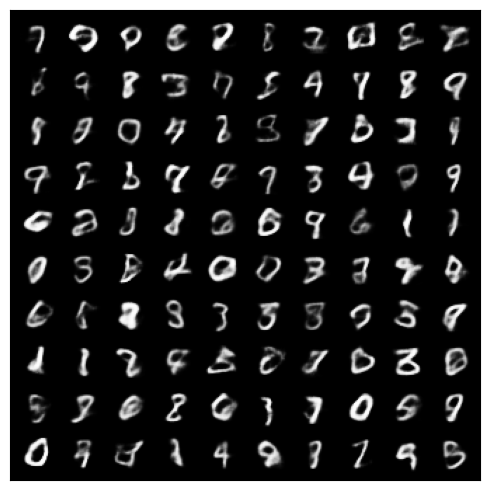

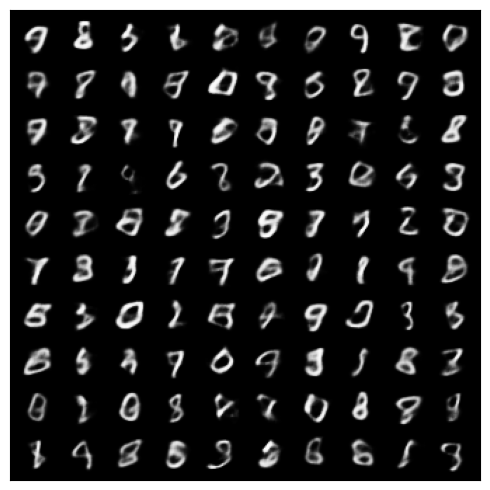

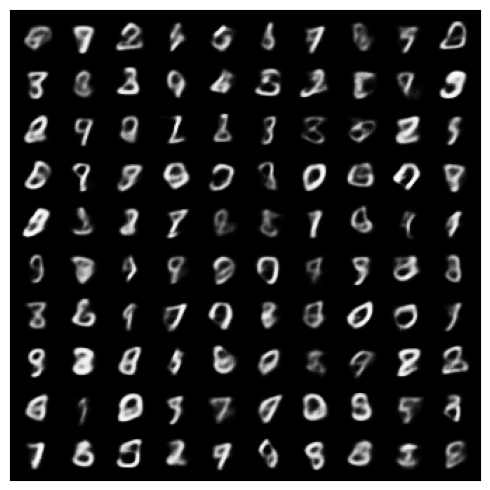

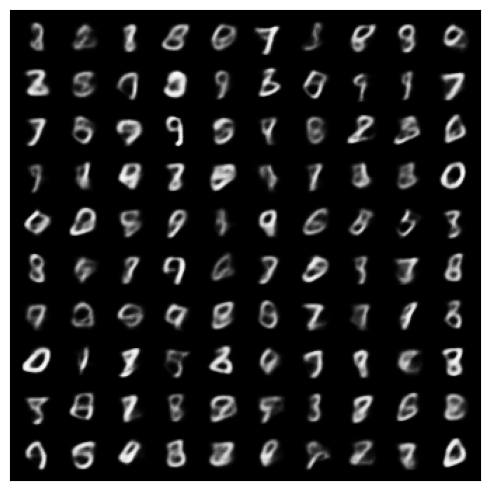

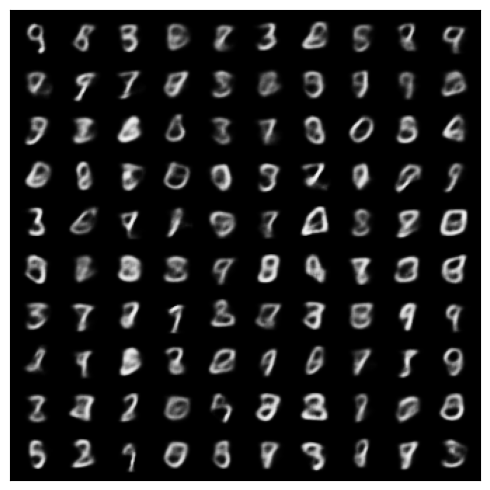

In [58]:
muss = []

last_vae = vae_init

for gen_number in range(5):
  print(gen_number)

  vae_gen = VariationalAutoencoder()
  vae_gen = vae_gen.to(device)

  train_vae_gen(vae_gen, True, last_vae)

  last_vae = vae_gen

  latent = torch.randn(100, latent_dims, device=device)
  img_recon = vae_gen.decoder(latent)

  img_recon = img_recon.cpu()

  fig, ax = plt.subplots(figsize=(5, 5))
  show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
  # plt.show()
  plt.xticks([])
  plt.yticks([])

  plt.tight_layout()

  plt.savefig(f"vae_gen{gen_number}.pdf")
  files.download(f"vae_gen{gen_number}.pdf")

  mus, vars   = vae_init.encoder(img_recon.to('cuda'))
  mus = mus.cpu().detach().numpy(); vars = vars.cpu().detach().numpy()

  muss.append(mus)

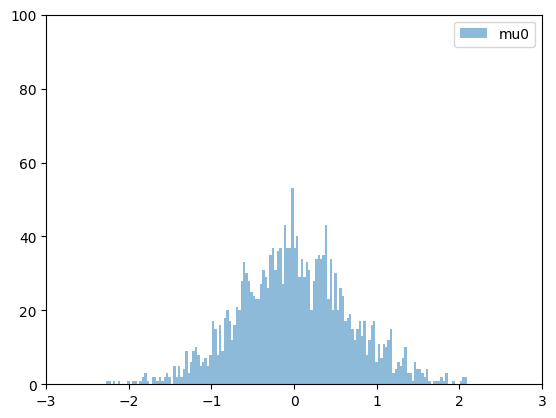

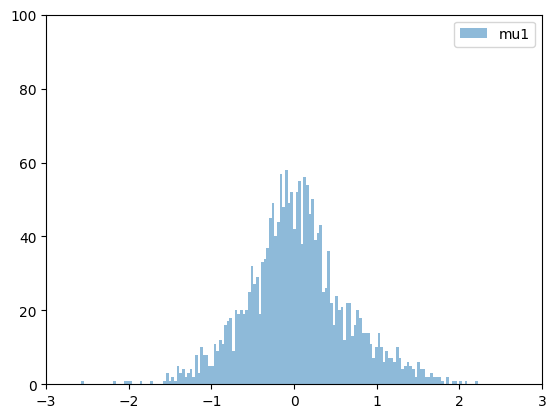

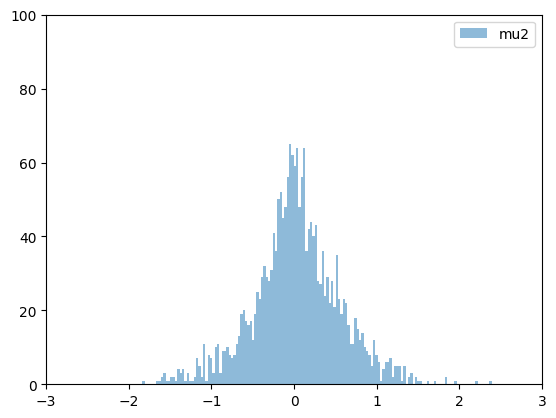

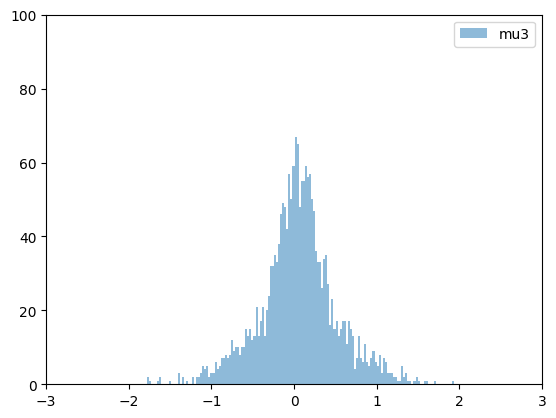

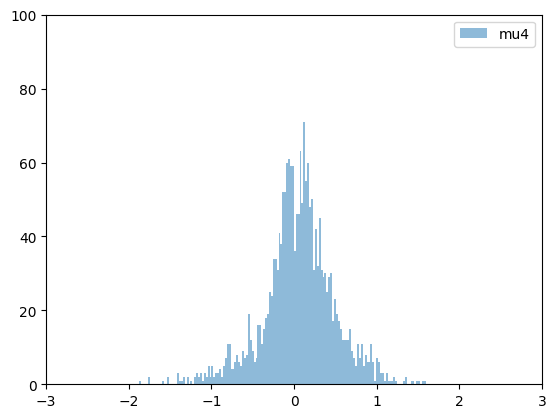

In [59]:
for i, mus in enumerate(muss):
  plt.figure()
  plt.hist(mus.flatten(), bins=150, label = f"mu{i}", alpha=0.5)
  plt.xlim(-3,3)
  plt.ylim(0, 100)
  plt.legend()
  plt.show()

tensor([[ 0.0656,  0.1991,  0.4961,  ...,  0.3684, -0.8658,  0.2554],
        [-0.1341, -0.0589, -1.0534,  ..., -0.7764,  0.6630, -0.4401],
        [ 0.0251, -0.1646,  0.1694,  ...,  0.7262, -0.4703,  0.1944],
        ...,
        [ 0.5887,  0.1486,  0.2740,  ...,  0.2964,  0.3385, -0.0076],
        [ 0.4643, -0.1319,  1.1600,  ...,  0.1608, -0.1815,  0.2654],
        [ 0.3619,  0.0188,  0.4726,  ...,  0.0185, -0.5806,  0.3675]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

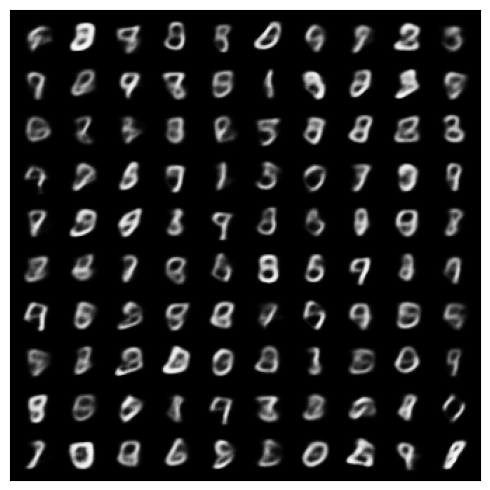

In [60]:
from google.colab import files
latent = torch.randn(128, latent_dims, device=device)

# reconstruct images from the latent vectors
img_recon = last_vae.decoder(latent)
mus, vars   = vae_init.encoder(img_recon.to('cuda'))
print(mus)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig("vae_epoch20.pdf")
files.download("vae_epoch20.pdf")

Gen 0 0.0037199787 0.67357385
Gen 1 0.037649374 0.60761327
Gen 2 0.028401546 0.5273319
Gen 3 0.051906876 0.46807787
Gen 4 0.055885438 0.43289876


<ipython-input-61-44e1152a98ae>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals, hist=False, kde=True,
<ipython-input-61-44e1152a98ae>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals, hist=False, kde=True,
<ipython-input-61-44e1152a98ae>:10: UserWarning: 

`distpl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

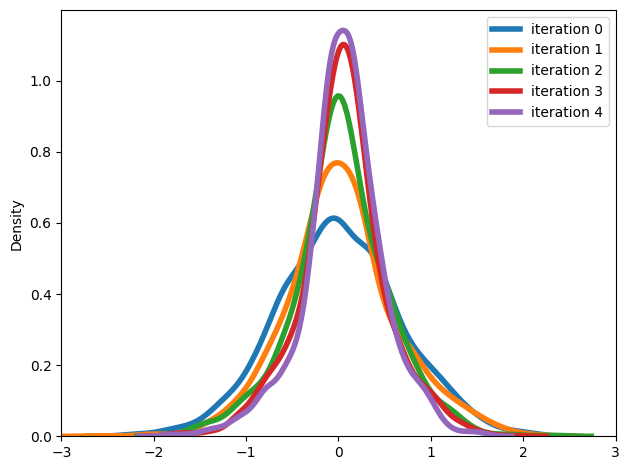

In [61]:
import seaborn as sns


plt.figure()

for i, mus in enumerate(muss):
  vals = mus.flatten()
  print(f"Gen {i}", np.mean(vals), np.std(vals))
  if i<10:
    sns.distplot(vals, hist=False, kde=True,
              bins=int(100),
              #  hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 4}, label=f"iteration {i}")
plt.xlim(-3,3)
plt.legend()
plt.tight_layout()
plt.savefig("iters.pdf")
files.download("iters.pdf")


In [1]:

# mu_sig = [
#   [
#     (0.014538932, 0.6995303),
#     (0.032151498, 0.60134965),
#     (-0.012714024, 0.5541111),
#     (0.0055421903, 0.48931533),
#     (0.013153562, 0.46653777)
#   ],
#   [
#     (-0.012844566, 0.69527394),
#     (0.018827086, 0.59368867),
#     (-0.015168274, 0.5296458),
#     (-0.019374713, 0.48430806),
#     (-0.014797333, 0.4310458),
#   ],
#   [
#     (-0.012720791, 0.6922824),
#     (-0.029163573, 0.60909194),
#     (-0.009332741, 0.53359216),
#     (-0.012893185, 0.4891546),
#     (-0.031725854, 0.45829764),
#   ],
#   [
#   (0.022953195, 0.67841727),
#   (0.045430116, 0.605033),
#   (0.05141772, 0.52345085),
#   (0.047837593, 0.48296788),
#   (0.07407785, 0.42802373),
#   ],
#   [
#     (0.0037199787, 0.67357385),
#     (0.037649374, 0.60761327),
#     (0.028401546, 0.5273319),
#     (0.051906876, 0.46807787),
#     (0.055885438, 0.43289876),
#   ],
# ]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

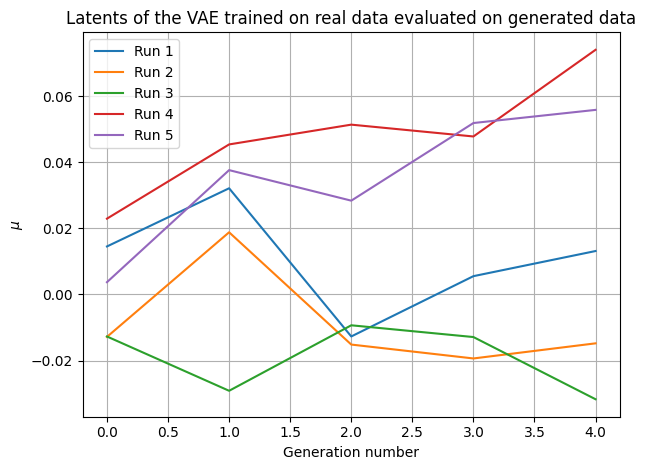

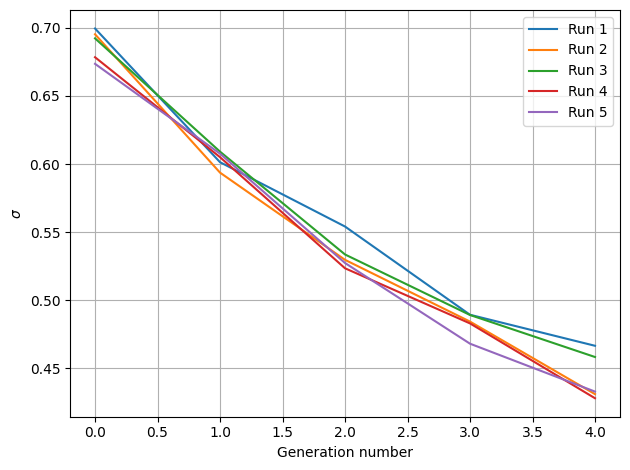

In [2]:
# import matplotlib.pyplot as plt
# from google.colab import files

# for ind, what in [(0, "$\mu$"), (1, "$\sigma$")]:
#   plt.figure()
#   for i, run in enumerate(mu_sig):
#     plt.plot([x[ind] for x in run], label=f"Run {i+1}")
#   plt.legend()
#   if ind == 0:
#     plt.title("Latents of the VAE trained on real data evaluated on generated data")

#   plt.ylabel(what)
#   plt.xlabel("Generation number")
#   plt.grid()
#   plt.tight_layout()

#   name = f"vae_{ind}.pdf"
#   plt.savefig(name)
#   files.download(name)